In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

# always import gbm_algos first !
import xgboost, lightgbm, catboost
from gplearn.genetic import SymbolicRegressor

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from utils import *
from preprocess import *

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew
# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder

from tqdm import trange

In [2]:
include_N_res = True

DATA_PATH = '../PDE_FIND_experimental_datasets/kdv.mat'
X, T, Exact = space_time_grid(data_path=DATA_PATH, real_solution=True)
X_star, u_star = get_trainable_data(X, T, Exact)

# Doman bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

N = 500
print(f"Training with {N} samples")
idx = np.random.choice(X_star.shape[0], N, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx,:]

# Unsup data
if include_N_res:
    N_res = N//2
    idx_res = np.array(range(X_star.shape[0]-1))[~idx]
    idx_res = np.random.choice(idx_res.shape[0], N_res, replace=True)
    X_res = X_star[idx_res, :]
    print(f"Training with {N_res} unsup samples")
    X_u_train = np.vstack([X_u_train, X_res])
    u_train = np.vstack([u_train, torch.rand(X_res.shape[0], 1) - 1000])
    # del X_res
else: print("Not including N_res")
    
# Convert to torch.tensor
X_u_train = to_tensor(X_u_train, True)
u_train = to_tensor(u_train, False)
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)

# lb and ub are used in adversarial training
scaling_factor = 1.0
lb = scaling_factor*to_tensor(lb, False)
ub = scaling_factor*to_tensor(ub, False)

# Feature names
feature_names=('uf', 'u_x', 'u_xx', 'u_xxx')

Training with 500 samples
Training with 250 unsup samples


In [3]:
fdc = FinDiffCalculator(X, T, Exact)
fd_u_t = to_tensor(fdc.finite_diff(1, diff_order=1), False)[idx, :]
fd_derivatives = fdc.finite_diff_from_feature_names(feature_names)
for d in fd_derivatives: fd_derivatives[d] = to_tensor(fd_derivatives[d], False)

dx = 0.1171875
dt = 0.1


In [4]:
tmp = None
for f in feature_names:
    print('Concatenating', f)
    if tmp == None: tmp = fd_derivatives[f]
    else: tmp = torch.cat([tmp, fd_derivatives[f]], dim=-1)
fd_derivatives = tmp[idx, :]; del tmp;
# fd_derivatives, fd_u_t

Concatenating uf
Concatenating u_x
Concatenating u_xx
Concatenating u_xxx


In [5]:
class Network(nn.Module):
    def __init__(self, model, index2features=None, scale=False, lb=None, ub=None):
        super(Network, self).__init__()
        # pls init the self.model before
        self.model = model
        # For tracking, the default tup is for the burgers' equation.
        self.index2features = index2features
        print("Considering", self.index2features)
        self.diff_flag = diff_flag(self.index2features)
        self.uf = None
        self.scale = scale
        self.lb, self.ub = lb, ub
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x, t):
        if not self.scale: self.uf = self.model(torch.cat([x, t], dim=1))
        else: self.uf = self.model(self.neural_net_scale(torch.cat([x, t], dim=1)))
        return self.uf
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        u_t = self.gradients(uf, t)[0]
        
        ### PDE Loss calculation ###
        # Without calling grad
        derivatives = []
        for t in self.diff_flag[0]:
            if t=='uf': derivatives.append(uf)
            elif t=='x': derivatives.append(x)
        # With calling grad
        for t in self.diff_flag[1]:
            out = uf
            for c in t:
                if c=='x': out = self.gradients(out, x)[0]
                elif c=='t': out = self.gradients(out, t)[0]
            derivatives.append(out)
        
        return torch.cat(derivatives, dim=1), u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))
    
    def neural_net_scale(self, inp):
        return 2*(inp-self.lb)/(self.ub-self.lb)-1

In [6]:
class SeclectorNetwork(nn.Module):
    def __init__(self, X_train_dim, bn=None):
        super().__init__()
        # Nonlinear model, Training with PDE reg.
        self.nonlinear_model = TorchMLP(dimensions=[X_train_dim, 50, 50, 1], activation_function=nn.Tanh, bn=bn, dropout=nn.Dropout(p=0.1), inp_drop=False)
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def forward(self, inn):
        ut_approx = self.nonlinear_model(inn)
        return ut_approx
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        return mse_loss

class AttentionSelectorNetwork(nn.Module):
    def __init__(self, layers, prob_activation=torch.sigmoid, bn=None, reg_intensity=0.25):
        super(AttentionSelectorNetwork, self).__init__()
        # Nonlinear model, Training with PDE reg.
        assert len(layers) > 1
        self.linear1 = nn.Linear(layers[0], layers[0])
        self.prob_activation = prob_activation
        self.nonlinear_model = TorchMLP(dimensions=layers, activation_function=nn.Tanh, bn=bn, dropout=nn.Dropout(p=0.1))
        self.latest_weighted_features = None
        self.th = 1/layers[0]
        self.reg_intensity = reg_intensity
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, inn):
        return self.nonlinear_model(inn*self.weighted_features(inn))
    
    def weighted_features(self, inn):
        self.latest_weighted_features = self.prob_activation(self.linear1(inn)).mean(axis=0)
        return self.latest_weighted_features
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        return mse_loss+self.reg_intensity*torch.norm(F.relu(self.latest_weighted_features-self.th), p=0)

# Only the SemiSupModel has changed to work with the finite difference guidance
class SemiSupModel(nn.Module):
    def __init__(self, network, selector, normalize_derivative_features=False, mini=None, maxi=None):
        super(SemiSupModel, self).__init__()
        self.network = network
        self.selector = selector
        self.normalize_derivative_features = normalize_derivative_features
        self.mini = mini
        self.maxi = maxi
    def forward(self, X_u_train, fd_derivatives=None, fd_weight=0.1):
        X_selector, y_selector = self.network.get_selector_data(*dimension_slicing(X_u_train))
        if self.normalize_derivative_features:
            X_selector = (X_selector-self.mini)/(self.maxi-self.mini)
        unsup_loss = self.selector.loss(X_selector, y_selector)
        if fd_derivatives is not None:
            r = fd_derivatives.shape[0]
            # Traditional MSE Loss btw uf and u_train + the fd_guidance loss
            fd_guidance = F.mse_loss(X_selector[:r, 0:1], fd_derivatives[:, 0:1])
            fd_guidance += fd_weight*(((X_selector[:r, 1:]-fd_derivatives[:, 1:])**2).mean(axis=0)).sum()
            return fd_guidance, unsup_loss
        return self.network.uf, unsup_loss

In [7]:
# network = Network(model=TorchMLP(dimensions=[6, 50, 50, 50 ,50, 50, 1], bn=nn.BatchNorm1d))
# selector = SeclectorNetwork(X_train_dim=6, bn=nn.LayerNorm)

### Version without normalized derivatives ###
# semisup_model = SemiSupModel(network=Network(model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1], activation_function=nn.Tanh, bn=nn.LayerNorm, dropout=None)),
#                              selector=SeclectorNetwork(X_train_dim=6, bn=nn.LayerNorm),
#                              normalize_derivative_features=False, 
#                              mini=None, 
#                              maxi=None)

### Version with normalized derivatives ###
# pretrained_state_dict = torch.load("./saved_path_inverse_kdv/semisup_model_with_LayerNormDropout_without_physical_reg_trained10000labeledsamples_trained5000unlabeledsamples_1.1e-07.pth")
pretrained_state_dict = None
network_state_dict = None
use_pretrained_weights = False
lets_pretrain = True

# semisup_model = SemiSupModel(network=Network(
#                                     model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1],
#                                                    activation_function=nn.Tanh,
#                                                    bn=nn.LayerNorm, dropout=None),
#                                     index2features=feature_names),
#                             selector=SeclectorNetwork(X_train_dim=len(feature_names), bn=nn.LayerNorm),
#                             normalize_derivative_features=True,
#                             mini=None,
#                             maxi=None)

semisup_model = SemiSupModel(network=Network(
                                    model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1],
                                                   activation_function=nn.Tanh,
                                                   bn=nn.LayerNorm, dropout=None),
                                    index2features=feature_names, scale=True, lb=lb, ub=ub),
                            selector=AttentionSelectorNetwork([len(feature_names), 50, 50, 1], prob_activation=nn.Softmax(dim=1), bn=nn.LayerNorm),
                            normalize_derivative_features=True,
                            mini=None,
                            maxi=None)

if use_pretrained_weights:
    print("Use pretrained weights")
    semisup_model.load_state_dict(pretrained_state_dict)
    network_state_dict = semisup_model.network.state_dict()
    semisup_model.eval()
    referenced_derivatives, u_t = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
    semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)

Using old implementation of TorchMLP. See models.py for more new model-related source code.
Considering ('uf', 'u_x', 'u_xx', 'u_xxx')
Using old implementation of TorchMLP. See models.py for more new model-related source code.


In [8]:
if lets_pretrain:
    print("Pretraining")
    pretraining_optimizer = LBFGSNew(semisup_model.network.parameters(), 
                                     lr=1e-1, max_iter=300, 
                                     max_eval=int(300*1.25), history_size=150, 
                                     line_search_fn=True, batch_mode=False)

    semisup_model.train()
    for i in range(300):
        def pretraining_closure():
            global N, X_u_train, u_train
            if torch.is_grad_enabled():
                pretraining_optimizer.zero_grad()
            # Only focusing on first [:N, :] elements
            mse_loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_u_train))[:N, :], u_train[:N, :])
            if mse_loss.requires_grad:
                mse_loss.backward(retain_graph=False)
            return mse_loss

        pretraining_optimizer.step(pretraining_closure)

        l = pretraining_closure()
        if (i % 100) == 0:
            curr_loss = l.item()
            print("Epoch {}: ".format(i), curr_loss)

            # Sneak on the test performance...
            semisup_model.network.eval()
            test_performance = F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item()
            string_test_performance = scientific2string(test_performance)
            print('Test MSE:', string_test_performance)
    
    print("Computing derivatives features")
    semisup_model.eval()
    referenced_derivatives, _ = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
    semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)

Pretraining
Epoch 0:  0.0062194461934268475
Test MSE: 6.5e-03
Epoch 100:  3.6511161738417286e-07
Test MSE: 3.1e-06
Epoch 200:  1.9826065056349762e-07
Test MSE: 1.7e-06
Computing derivatives features


In [9]:
def pcgrad_closure():
    global N, X_u_train, u_train, fd_derivatives
    fd_guidance, unsup_loss = semisup_model(X_u_train, fd_derivatives)
    losses = [fd_guidance, unsup_loss]
    updated_grads = []
    
    for i in range(2):
        optimizer1.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in semisup_model.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(semisup_model.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    return sum(losses)

def closure():
    global N, X_u_train, u_train
    if torch.is_grad_enabled():
        optimizer2.zero_grad()
    mse_loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_u_train))[:N, :], u_train)
    if mse_loss.requires_grad:
        mse_loss.backward(retain_graph=True)
    return mse_loss

def selector_closure():
    global ders, dys
    if torch.is_grad_enabled():
        optimizer3.zero_grad()
    unsup_loss = semisup_model.selector.loss(ders, dys)
    if unsup_loss.requires_grad:
        unsup_loss.backward(retain_graph=True)
    return unsup_loss

Learning rate finding


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.21E-06


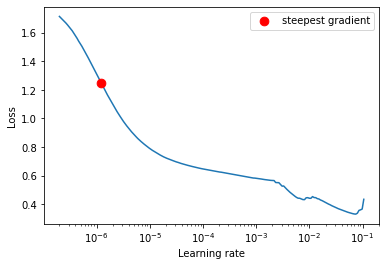

In [10]:
params = semisup_model.parameters()

### For SGD and Adam ###
learning_rate1, learning_rate2 = 1e-7, 1e-1

### For LBFGS (a good choice already!!!) ###
# print("Using LBFGS's learning rate set")
# learning_rate1, learning_rate2 = 8e-2, 5e-2 # (1e-1, 5e-2) is also OK!

choice = 'MAD'; auto_lr = True
if choice == 'LBFGS':
    optimizer1 = torch.optim.LBFGS(params, lr=learning_rate1, 
                                   max_iter=100, max_eval=125, 
                                  history_size=120, line_search_fn='strong_wolfe')
if choice == 'Adam':
    optimizer1 = AdamGC(params, lr=learning_rate1, use_gc=True, gc_conv_only=False, gc_loc=False)
if choice == 'SGD':
    optimizer1 = SGDGC(params, lr=learning_rate1, use_gc=True, nesterov=True, momentum=0.95)
if choice == 'MAD':
    optimizer1 = MADGRAD(params, lr=learning_rate1, momentum=0.9)

if choice != 'LBFGS' and auto_lr:
    print('Learning rate finding')
    bs = 4000; bs = X_u_train.shape[0] if bs>X_u_train.shape[0] else bs
    criterion = LadderLoss(return_list=True)
    trainloader = get_dataloader(X_u_train, u_train, bs=bs)
    
    lr_finder = LRFinder(semisup_model, optimizer=optimizer1, 
                         closure=pcgrad_update, criterion=criterion, device="cpu")
    lr_finder.range_test(trainloader, val_loader=None, end_lr=100, num_iter=300)
    
    # to inspect the loss-learning rate graph
    suggested_lr, _ = lr_finder.plot()
    # To prevent divergence during the second stage training.
    # suggested_lr = min(suggested_lr, 5e-3)
    lr_finder.reset(); plt.show()

else:
    lr_finder = None
    suggested_lr = None

In [11]:
print("Deleted the fake labels used in Learning rate finder")
u_train = u_train[:N, :]

# suggested_lr = 1e-4

if lr_finder and suggested_lr:
    optimizer1 = lr_finder.optimizer

print("Assigning the suggested_lr to optimizer1")
for g in optimizer1.param_groups:
    g['lr'] = suggested_lr

epochs1 = 300; epochs2 = 500;

Deleted the fake labels used in Learning rate finder
Assigning the suggested_lr to optimizer1


In [12]:
# Setting up the generator
generator = TorchMLP([2, 50, 50, 2])
# generator_training_epochs indicates how string the generator is
adv_f = 100; generator_training_epochs = 300; generator_training_limit = epochs1-100
# I can use the Learning rate finder to find a good lr for the generator optim  as well
generator_optimizer = torch.optim.SGD(generator.parameters(), lr=3e-4, momentum=0.95)

Using old implementation of TorchMLP. See models.py for more new model-related source code.


In [13]:
curr_loss = 500; F_print = 10 if choice == 'LBFGS' else 100

# Stage I
# How long should I pretrain selector part of the model?
for i in range(epochs1):
    if i%adv_f==0 and i<=generator_training_limit:
        best_generator_loss = 1000; best_generator_state_dict = None
        o_tensor = X_u_train[:N, :] # or X_u_train ?
        print("Training the generator for ")
        for _ in trange(generator_training_epochs):
            semisup_model.eval()
            generator.train()
            generator_optimizer.zero_grad()
            X_gen = scale_to_range(generator(o_tensor), lb, ub)
            unsup_loss = semisup_model(X_gen)[1]
#                 d_loss = F.mse_loss(X_gen, o_tensor)
            d_loss = F.mse_loss(X_gen, o_tensor)
            generator_loss = d_loss-unsup_loss
            generator_loss.backward(retain_graph=True)
            generator_optimizer.step()
            # Saving the best_generator_state_dict
            if generator_loss.item() < best_generator_loss:
                best_generator_loss = generator_loss.item()
                best_generator_state_dict = generator.state_dict()

        print("The best generator loss:", best_generator_loss)
        generator.load_state_dict(best_generator_state_dict)
        generator.eval()
        X_gen = scale_to_range(generator(o_tensor), lb, ub)
        if N_res<X_gen.shape[0]: X_gen = sampling_from_rows(X_gen, N_res)
        X_u_train = torch.cat([X_u_train[:N, :], X_gen], dim=0).detach().requires_grad_(True)

    semisup_model.train()
    generator_optimizer.zero_grad()
    optimizer1.step(pcgrad_closure)
    l = pcgrad_closure()
    if (i % F_print) == 0:
        if l.item() != curr_loss:
            curr_loss = l.item()
        else:
            print("Semi-supervised solver loss @Epoch {}: ".format(i), curr_loss)
            print("Finishing the first stage")
            break
        print("Semi-supervised solver loss @Epoch {}: ".format(i), curr_loss)

  0%|          | 0/300 [00:00<?, ?it/s]

Training the generator for 


100%|██████████| 300/300 [00:30<00:00,  9.70it/s]


The best generator loss: 1.8253214359283447
Semi-supervised solver loss @Epoch 0:  1.8505711555480957


  0%|          | 1/300 [00:00<00:30,  9.80it/s]

Training the generator for 


100%|██████████| 300/300 [00:28<00:00, 10.66it/s]


The best generator loss: 2.662322521209717
Semi-supervised solver loss @Epoch 100:  0.7217603921890259


  0%|          | 1/300 [00:00<00:31,  9.59it/s]

Training the generator for 


100%|██████████| 300/300 [00:28<00:00, 10.67it/s]


The best generator loss: 0.4372144937515259
Semi-supervised solver loss @Epoch 200:  0.7135145664215088


In [14]:
optimizer2 = LBFGSNew(semisup_model.network.parameters(), 
                              lr=learning_rate2, max_iter=300, max_eval=int(300*1.25),
                              history_size=150, line_search_fn=True, batch_mode=False)

curr_loss = 1000
# Stage II: Train semisup_model.network
semisup_model.network.train()
semisup_model.selector.eval()
for i in range(epochs2):
    optimizer2.step(closure)
    l = closure()
    if (i % 100) == 0:
        if l.item() != curr_loss:
            curr_loss = l.item()
        print("Epoch {}: ".format(i), curr_loss)

Epoch 0:  1.800115398964408e-07
Epoch 100:  1.093455423983869e-07
Epoch 200:  7.366666920916032e-08
Epoch 300:  4.9396906121046413e-08
Epoch 400:  3.7593853363659946e-08


In [15]:
print("Testing")
semisup_model.network.eval()
# Compare btw the two semi-supervise learning?
test_performance = F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item()
string_test_performance = scientific2string(test_performance)
print('Test MSE:', string_test_performance)

Testing
Test MSE: 8.5e-07


In [16]:
# print("Saving")
# MODEL_PATH = './saved_path_inverse_kdv/semisup_model_with_LayerNormDropout_without_physical_reg_trained10000labeledsamples_trained5000unlabeledsamples_'+string_test_performance+'.pth'
# torch.save(semisup_model.state_dict(), MODEL_PATH)

In [17]:
(semisup_model.selector.latest_weighted_features).detach().numpy()

array([0.26908094, 0.11279472, 0.41611353, 0.20201078], dtype=float32)

In [18]:
ders, dys = semisup_model.network.get_selector_data(*dimension_slicing(X_u_train))

optimizer3 = LBFGSNew(semisup_model.selector.parameters(), 
                      lr=learning_rate2, max_iter=300, max_eval=int(300*1.25),
                      history_size=150, line_search_fn=True, batch_mode=False)

# Stage II: Train semisup_model.selector
semisup_model.network.eval()
semisup_model.selector.train()
for i in range(30):
    optimizer3.step(selector_closure)
    l = selector_closure()
    if (i % 5) == 0:
        print("Epoch {}: ".format(i), l.item())
        print(np.argsort((semisup_model.selector.latest_weighted_features).detach().numpy()))

Epoch 0:  0.5013038516044617
[3 1 2 0]
Epoch 5:  0.2502424418926239
[3 0 2 1]
Epoch 10:  0.25025448203086853
[3 0 2 1]
Epoch 15:  0.25022879242897034
[3 0 2 1]
Epoch 20:  0.2502342760562897
[3 0 2 1]
Epoch 25:  0.25023016333580017
[3 0 2 1]


In [19]:
feature_importance = (semisup_model.selector.latest_weighted_features).detach().numpy()
feature_importance = feature_importance
print("--- Feature importance ranking ---")
for idx in np.argsort(feature_importance)[::-1]:
    print(feature_names[idx], feature_importance[idx])

--- Feature importance ranking ---
u_x 0.38784292
u_xx 0.21303304
uf 0.20414495
u_xxx 0.1949791


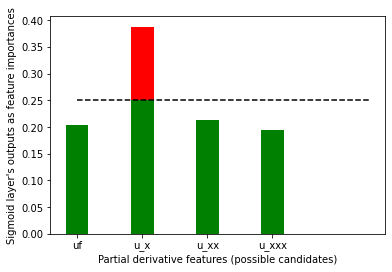

In [25]:
def plot_feature_importance_neural_net(feature_importances, feature_names, threshold=0.5, save_path=None):
    # split it up
    above_threshold = np.maximum(feature_importance - threshold, 0)
    below_threshold = np.minimum(feature_importance, threshold)

    # and plot it
    fig, ax = plt.subplots()
    ax.bar(feature_names, below_threshold, 0.35, color="g")
    ax.bar(feature_names, above_threshold, 0.35, color="r",
            bottom=below_threshold)
    # horizontal line indicating the threshold
    ax.plot([0., 4.5], [threshold, threshold], "k--")
    plt.xlabel("Partial derivative features (possible candidates)")
    plt.ylabel("Sigmoid layer's outputs as feature importances")
    
    if save_path is not None: fig.savefig(save_path, dpi=200)

plot_feature_importance_neural_net(feature_importance, feature_names,threshold=1/len(feature_names), save_path='../visualization/kdv_feature_importances_selector_with_softmax.png')

In [21]:
# ders, dys = semisup_model.network.get_selector_data(*dimension_slicing(X_u_train))
# features_searcher = pyGRNN_feature_selection(ders, dys, feature_names)
# print(features_searcher.best_inSpaceIndex)
# print(features_searcher.best_inSpaceNames)

In [22]:
ders, dys = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
light = lightgbm.LGBMRegressor(n_estimators=300, learning_rate=0.1, reg_lambda=1)
light = SklearnModel(model=light, X_train=to_numpy(ders), y_train=to_numpy(dys).ravel(), feature_names=feature_names)
light_feature_importance = light.feature_importance()

Done training
Training MSE: 6.659896326837799e-07
('u_x', 0.35755555555555557)
('u_xxx', 0.26055555555555554)
('uf', 0.19944444444444445)
('u_xx', 0.18244444444444444)


In [23]:
tmp = sorted([(v, f) for (f, v) in light_feature_importance.items()])[::-1]
xxx = [f for (f, v) in tmp]
yyy = [v for (f, v) in tmp]

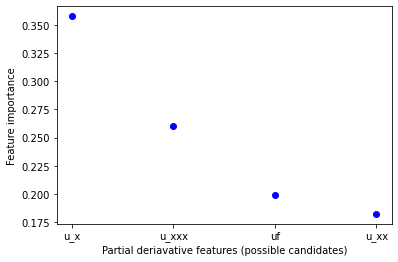

In [26]:
plt.plot(yyy, xxx, 'bo')
plt.ylabel("Feature importance")
plt.xlabel("Partial deriavative features (possible candidates)")
plt.savefig("../visualization/kdv_trees_feature_importances_with_softmax.png", dpi=200)
plt.show()